In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import Counter
plt.style.use("ggplot")#“Dessine mes graphiques avec le style ggplot.”


Chaque entrée de cet ensemble de données se compose d'un segment de texte représentant un message Twitter et d'une étiquette correspondante indiquant l'émotion prédominante exprimée. Les émotions sont classées en six catégories : 
- tristesse (0), 
- joie (1), 
- amour (2), 
- colère (3), 
- peur (4) et 
- surprise (5).\
Que vous soyez intéressé par l'analyse des sentiments, la classification des émotions ou l'exploration de texte, cet ensemble de données offre une base solide pour explorer le paysage émotionnel nuancé des médias sociaux.

### Chargement des données

In [3]:
data=pd.read_csv("text.csv")
data.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [4]:
data.shape

(416809, 3)

In [5]:
data.columns

Index(['Unnamed: 0', 'text', 'label'], dtype='object')

In [6]:
#Suppresion de la variable Unnamed
data.drop(["Unnamed: 0"],axis=1,inplace=True)

In [7]:
data.head(5)

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [8]:
X_train,X_test,y_train,y_test=train_test_split(data.drop(["label"],axis=1),data["label"],test_size=0.3, random_state=42)

### Analyse exploratoire

In [9]:
train=pd.concat([X_train,y_train],axis=1)

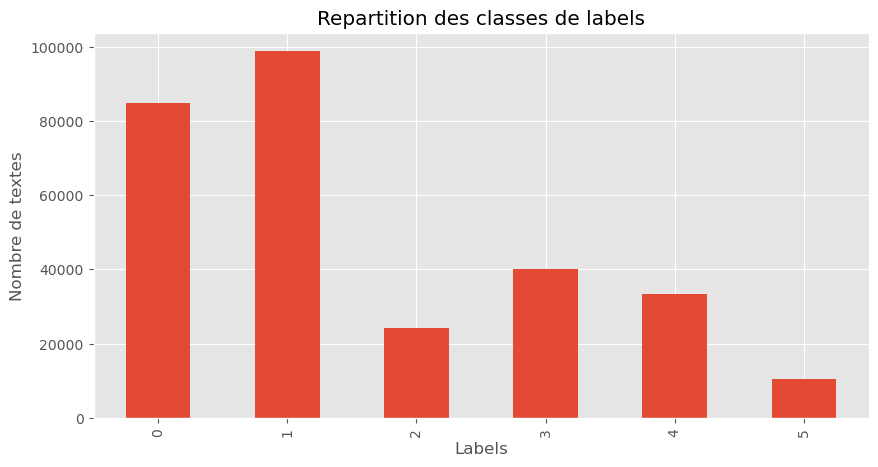

In [10]:
ax=train["label"].value_counts().sort_index().plot(
    kind='bar',title="Repartition des classes de labels",figsize=(10,5))
ax.set_xlabel("Labels")
ax.set_ylabel("Nombre de textes")
plt.show()

On observe un déséquilibre marqué entre les classes : la classe 1 (joie) est largement majoritaire avec près de 100 000 textes, tandis que la classe 5 (surprise) est très minoritaire.
Ce déséquilibre risque de biaiser l’apprentissage du modèle, qui pourrait avoir tendance à prédire la classe majoritaire (joie) au détriment des classes plus rares comme la surprise.

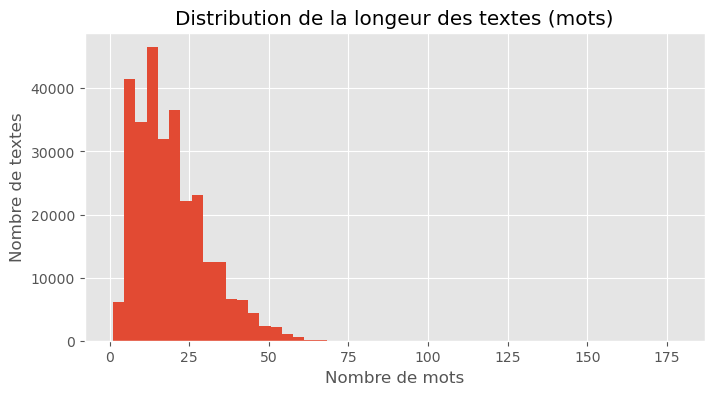

In [11]:
train["text_length"]=train["text"].apply(lambda x: len(str(x).split()))
train["text_length"].hist(bins=50,figsize=(8,4))
plt.title("Distribution de la longeur des textes (mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de textes")
plt.show()

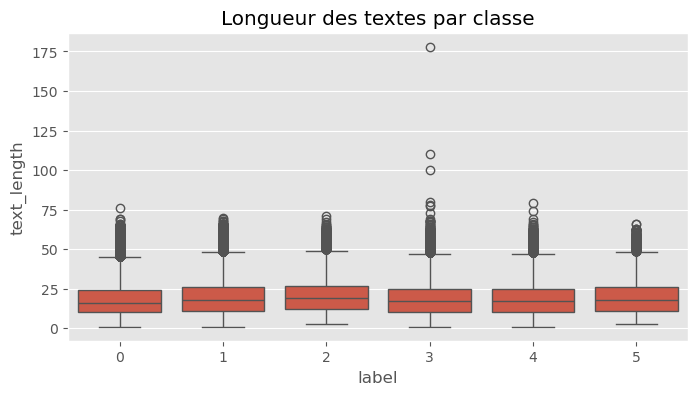

In [12]:
plt.figure(figsize=(8,4))
sns.boxplot(x="label",y="text_length",data=train)
plt.title("Longueur des textes par classe")
plt.show()

La repartition des textes est presque là même dans chaque classe 

In [13]:
def top_words(texts,n=10):
    words=" ".join(texts).lower().split()
    return Counter(words).most_common(n)

for label in sorted(train["label"].unique()):
    print(f"Classe {label} :")
    print(top_words(train[train["label"]==label]["text"],15))
    print("-"*50)

Classe 0 :
[('i', 139032), ('feel', 58999), ('and', 49388), ('to', 42736), ('the', 39392), ('a', 30427), ('feeling', 28683), ('of', 24699), ('that', 24203), ('my', 22317), ('in', 16543), ('it', 16167), ('like', 15528), ('so', 14460), ('for', 14309)]
--------------------------------------------------
Classe 1 :
[('i', 157665), ('feel', 71969), ('and', 60801), ('to', 59674), ('the', 55536), ('a', 39905), ('that', 34160), ('of', 31126), ('feeling', 28660), ('my', 26127), ('in', 22381), ('it', 20690), ('like', 17689), ('is', 16128), ('have', 16120)]
--------------------------------------------------
Classe 2 :
[('i', 39751), ('feel', 17220), ('and', 15694), ('the', 15137), ('to', 14786), ('a', 11063), ('of', 9397), ('that', 8238), ('my', 8148), ('feeling', 7255), ('in', 5577), ('like', 5367), ('it', 5058), ('for', 4738), ('me', 4274)]
--------------------------------------------------
Classe 3 :
[('i', 65076), ('feel', 26373), ('and', 23503), ('to', 21088), ('the', 19531), ('a', 15044), ('

La majorité des mots ne permettent pas de definir le sentiment car souvent des mots neutres en emotions.

In [14]:
print("Nombres de doublons : ", train.duplicated(subset="text").sum())
short_texts=train[train["text_length"]<=2]
print(f"Textes très courts : :{len(short_texts)}")
print(short_texts.head())

Nombres de doublons :  11331
Textes très courts : :74
               text  label  text_length
315252   every time      1            2
317573         once      3            1
390518      nothing      3            1
291076  no response      4            2
405165           in      0            1


In [39]:
#Focus sur les doublons
train['is_duplicate'] = train.duplicated(subset='text', keep=False)
duplicates=train[train["is_duplicate"]]
duplicates.head(5)

,text,label,text_length,is_duplicate
126061,i find baking to be so relaxing and enjoyable ...,2,36,True
336181,i feel a strange sense of calm,4,7,True
216847,i have told my mother that i have the agency t...,3,46,True
265930,i just feel like crawling in a hole and then w...,2,17,True
81627,im quiet private i feel things deeply im passi...,1,17,True


On retrouve ici toutes les textes doublons quelques soit le label c'est-à-dire qu'un texte peut apparaître en doublon dans un même label ou dans un label différent

Text(0, 0.5, 'Nombre de doublons')

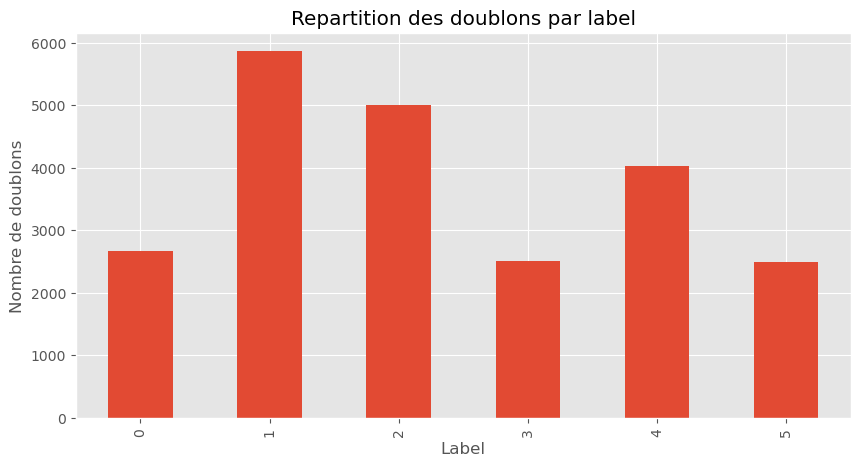

In [ ]:
ax=duplicates["label"].value_counts().sort_index().plot(
    kind="bar",title="Repartition des doublons par label",figsize=(10,5))
ax.set_xlabel("Label")
ax.set_ylabel("Nombre de doublons")


Nous allons procéder en deux étapes :
- 1) Déterminer et supprimer le cas écheant les doublons présents dans un même label
- 2) Analyser les doublons présents dans des labels très différents.

Pour rappel les émotions sont classés de la façon suivante :
- tristesse (0), 
- joie (1), 
- amour (2), 
- colère (3), 
- peur (4) et 
- surprise (5).

##### 1)Pareils doublons

In [ ]:
#supprimer les doublons où le text et le label sont identiques
train_clean = train.drop_duplicates(subset=["text", "label"])

print("Avant :", len(train))
print("Après suppression des doublons exacts :", len(train_clean))

Avant : 291766
Après suppression des doublons exacts : 291394


##### 2) Maintenant analysons les doublons de labels différents

In [89]:
#liste d'émotions contradictoires
contradictions = [
    [0, 1],  # tristesse + joie
    [0, 2],  # tristesse + amour
    [1, 3],  # joie + colère
    [1, 4]   # joie + peur
]

# Regrouper tous les labels associés à chaque texte
labels_per_text = train_clean.groupby("text")["label"].unique()
# Garder seulement les textes qui ont plusieurs labels différents
ambiguous_texts = labels_per_text[labels_per_text.apply(len) > 1]

# indices_per_text : liste des indices originaux par texte parce que chaque texte est un indice unique on va le recuperer après
indices_per_text = train_clean.groupby("text").apply(lambda x: x.index.tolist())

#Fonction pour comparer les emotions à un referentiel de contradictions
def label_contradiction(label,contradictions):
    for ref in contradictions:
        if sorted(ref)==sorted(label):
            return True
    else : return False
        
#on applique la fonction
contradictory_texts=labels_per_text[labels_per_text.apply(lambda x:label_contradiction(x,contradictions))]
#on recupère les index des contradictions 
contradictory_indices=indices_per_text.loc[contradictory_texts.index].explode().tolist()
train_clean = train_clean.drop(index=contradictory_indices)



/tmp/ipykernel_1263/3305276584.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices_per_text = train_clean.groupby("text").apply(lambda x: x.index.tolist())
